In [38]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
from sklearn.svm import SVR

### Data quality asessment and data cleaning

In [39]:
data = pd.read_csv("sp500_stocks.csv", parse_dates=["Date"])

In [40]:

colunas = [col for col in data.columns if col not in ["Symbol", "Date"]]

empresas_validas = data.groupby("Symbol").filter(
    lambda x: not x[colunas].isna().all().all()
)

#empresas_validas.to_csv("sp500_filtered.csv", index=False)



In [41]:
data_filtered = pd.read_csv("sp500_filtered.csv")

In [42]:
empresas_dataframes = {}

for symbol in data_filtered["Symbol"].unique():
    df_empresa = data_filtered[data_filtered["Symbol"] == symbol]
    empresas_dataframes[symbol] = df_empresa

# Acessar o dataframe de uma empresa específica, como AAPL
df_aapl = empresas_dataframes["ZBRA"]
print(df_aapl.head())

              Date Symbol  Adj Close      Close       High        Low  \
626918  2010-01-04   ZBRA  28.670000  28.670000  28.700001  28.070000   
626919  2010-01-05   ZBRA  28.620001  28.620001  29.370001  28.540001   
626920  2010-01-06   ZBRA  28.400000  28.400000  28.490000  27.320000   
626921  2010-01-07   ZBRA  27.690001  27.690001  28.299999  27.610001   
626922  2010-01-08   ZBRA  27.600000  27.600000  27.610001  27.280001   

             Open    Volume  
626918  28.469999  168800.0  
626919  28.549999  168800.0  
626920  27.410000  385300.0  
626921  28.230000  183600.0  
626922  27.580000  266500.0  


### Data pre-processing

Lagged Features

	•	Previous days values to predict future prices.

 Moving Averages

	•	Smooth data and trends over a window 

Volatility Indicators

	•	Standard deviation or percentage changes

Rate of Change (Momentum)

	•	Momentum of price movements

Relative Strength Index (RSI)

	•	Overbought or oversold conditions

In [43]:
from sklearn.preprocessing import MinMaxScaler

def preprocess_dataframe(df):
    # Garantir que estamos trabalhando com uma cópia do DataFrame
    df = df.copy()
    
    # Criar colunas de lags
    for lag in [1, 3, 7]:
        df.loc[:, f"Close_lag_{lag}"] = df["Close"].shift(lag)
    
    # Médias móveis e volatilidade
    df.loc[:, "MA_5"] = df["Close"].rolling(window=5).mean()
    df.loc[:, "MA_10"] = df["Close"].rolling(window=10).mean()
    df.loc[:, "Volatility_5"] = df["Close"].rolling(window=5).std()

    # Rate of Change (ROC)
    df.loc[:, "ROC_5"] = df["Close"].pct_change(periods=5)
    
    # Relative Strength Index (RSI)
    def calculate_rsi(data, window=14):
        delta = data["Close"].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window).mean()
        rs = gain / loss
        rsi = 100 - (100 / (1 + rs))
        return rsi
    
    df.loc[:, "RSI"] = calculate_rsi(df)
    
    # Criar coluna de Target
    df.loc[:, "Target"] = df["Close"].shift(-1)
    
    # Normalização
    '''scaler = MinMaxScaler()
    numeric_columns = [
        "Open", "High", "Low", "Close", "Volume",
        "Close_lag_1", "Close_lag_3", "Close_lag_7",
        "MA_5", "MA_10", "Volatility_5", "ROC_5", "RSI", "Target"
    ]'''
    
    # Aplicar escalonamento apenas nas colunas numéricas
    '''df[numeric_columns] = scaler.fit_transform(df[numeric_columns])'''
    
    # Preenchimento de valores ausentes
    df.ffill(inplace=True)
    df.bfill(inplace=True)
    
    return df

In [44]:
empresas_dataframes = {
    symbol: preprocess_dataframe(df)
    for symbol, df in empresas_dataframes.items()
}

### Exploratory Data Analysis

In [45]:
# Assuming 'empresas_dataframes' is a dictionary of dataframes
combined_df = pd.concat(
    [df.assign(Symbol=symbol) for symbol, df in empresas_dataframes.items()],
    ignore_index=True
)
print(combined_df.shape)  # Check the size of the combined dataframe

(630672, 17)


In [46]:
# General statistics for the entire dataset (across all companies)
print(combined_df.describe())

           Adj Close          Close           High            Low  \
count  630672.000000  630672.000000  630672.000000  630672.000000   
mean       98.398637     105.126039     106.531188     103.828162   
std       203.781150     204.296404     206.448339     201.992999   
min         1.030000       1.030000       1.108667       0.998667   
25%        25.751807      30.590000      31.760000      30.209999   
50%        48.711182      56.796843      57.400002      56.000000   
75%        98.205870     108.239998     109.410004     107.061249   
max      5224.279785    5224.279785    5237.000000    5185.040039   

                Open        Volume    Close_lag_1    Close_lag_3  \
count  630672.000000  6.306720e+05  630672.000000  630672.000000   
mean      105.159322  8.046516e+06     105.065660     104.945034   
std       204.203861  2.883494e+07     204.109839     203.736623   
min         1.030000  0.000000e+00       1.030000       1.030000   
25%        31.379999  8.484000e+05    

In [47]:
# Check missing data across all companies
print(combined_df.isnull().sum())

Date            0
Symbol          0
Adj Close       0
Close           0
High            0
Low             0
Open            0
Volume          0
Close_lag_1     0
Close_lag_3     0
Close_lag_7     0
MA_5            0
MA_10           0
Volatility_5    0
ROC_5           0
RSI             0
Target          0
dtype: int64


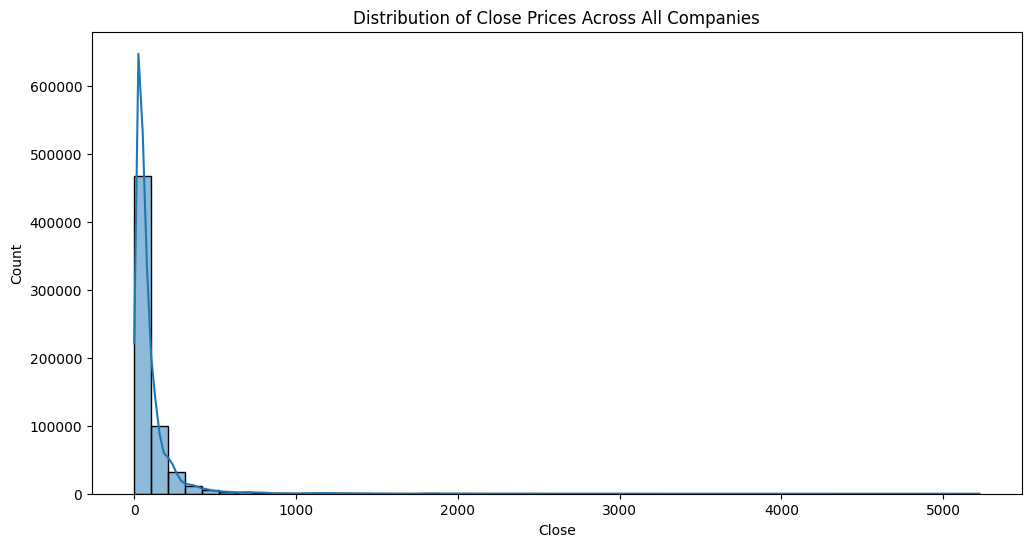

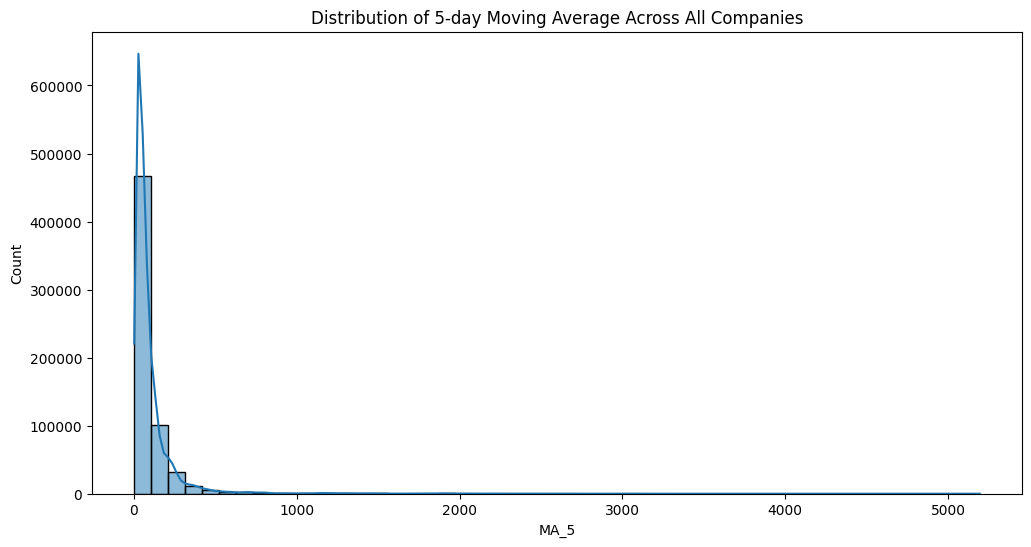

In [48]:
# Distribution of 'Close' prices for all companies
plt.figure(figsize=(12, 6))
sns.histplot(combined_df['Close'], kde=True, bins=50)
plt.title('Distribution of Close Prices Across All Companies')
plt.show()

# Distribution of moving averages across all companies
plt.figure(figsize=(12, 6))
sns.histplot(combined_df['MA_5'], kde=True, bins=50)
plt.title('Distribution of 5-day Moving Average Across All Companies')
plt.show()

# You can add more indicators in the same way

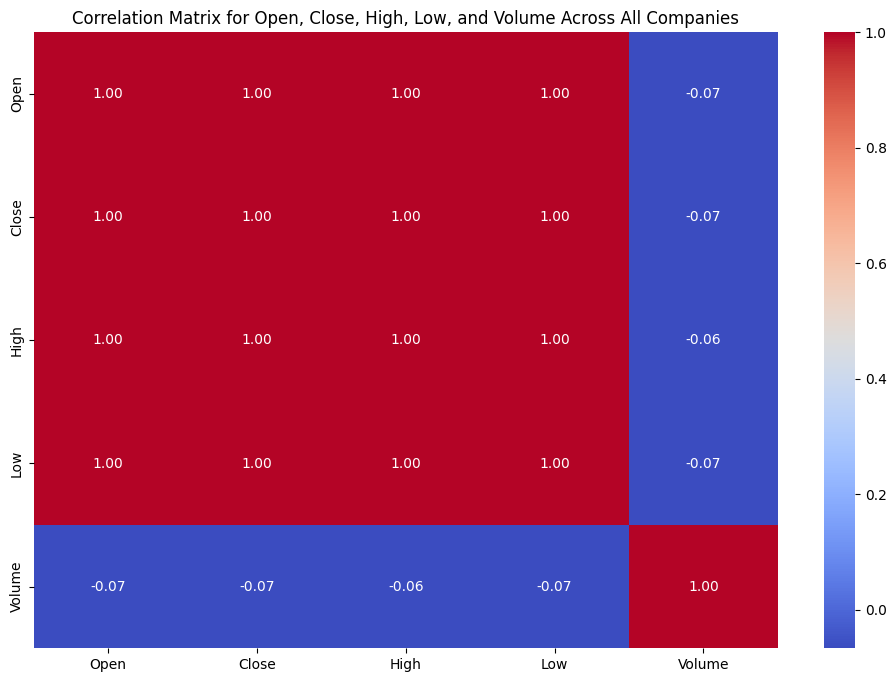

In [49]:
# Select only the relevant columns for correlation
relevant_columns = ['Open', 'Close', 'High', 'Low', 'Volume']
relevant_df = combined_df[relevant_columns]

# Calculate the correlation matrix
corr_matrix = relevant_df.corr()

# Plot the correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title('Correlation Matrix for Open, Close, High, Low, and Volume Across All Companies')
plt.show()

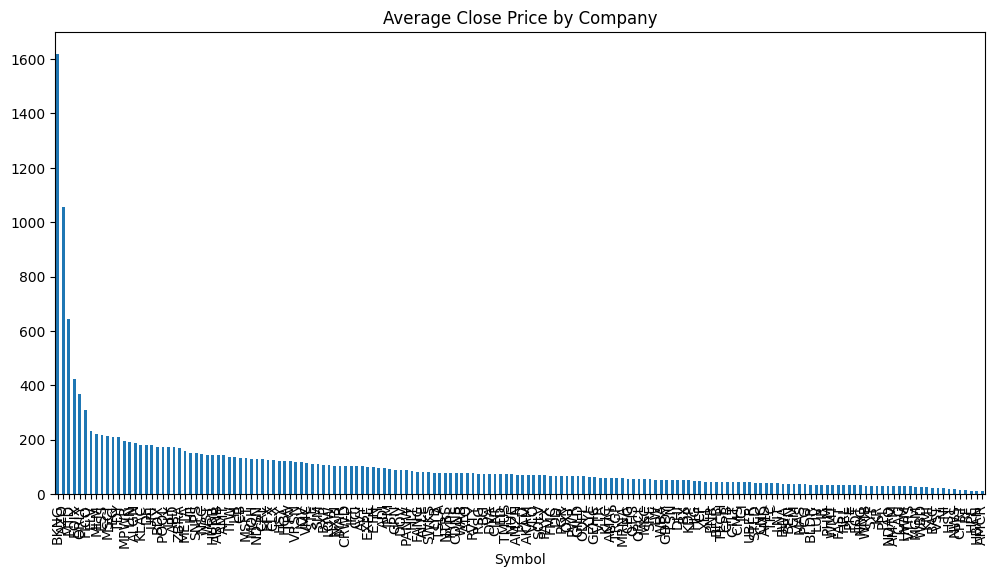

In [50]:
# Mean Close Price by Company
plt.figure(figsize=(12, 6))
avg_close_by_company = combined_df.groupby('Symbol')['Close'].mean().sort_values(ascending=False)
avg_close_by_company.plot(kind='bar')
plt.title('Average Close Price by Company')
plt.show()

# You can also compare other indicators, such as moving averages or volatility

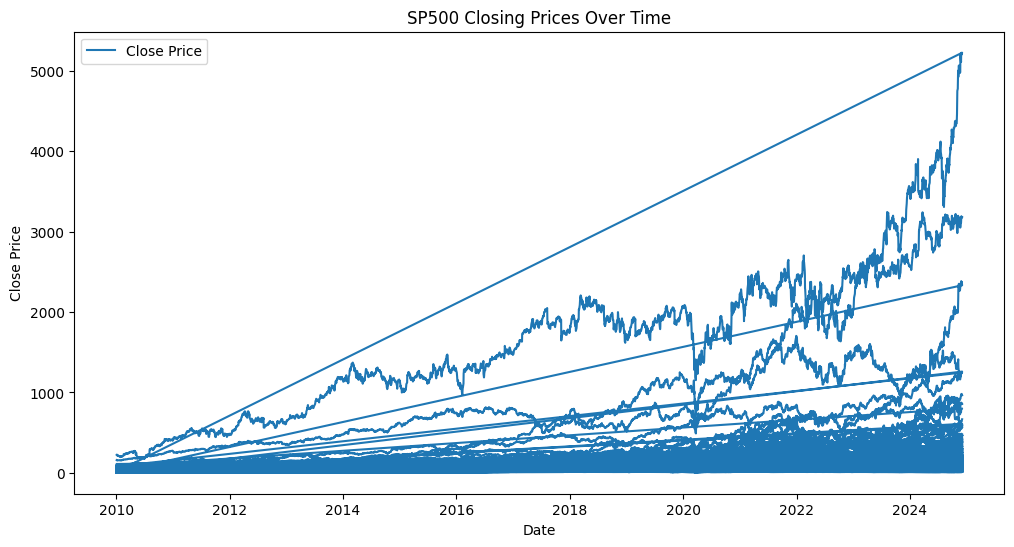

In [51]:

plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['Close'], label='Close Price')
plt.title('SP500 Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

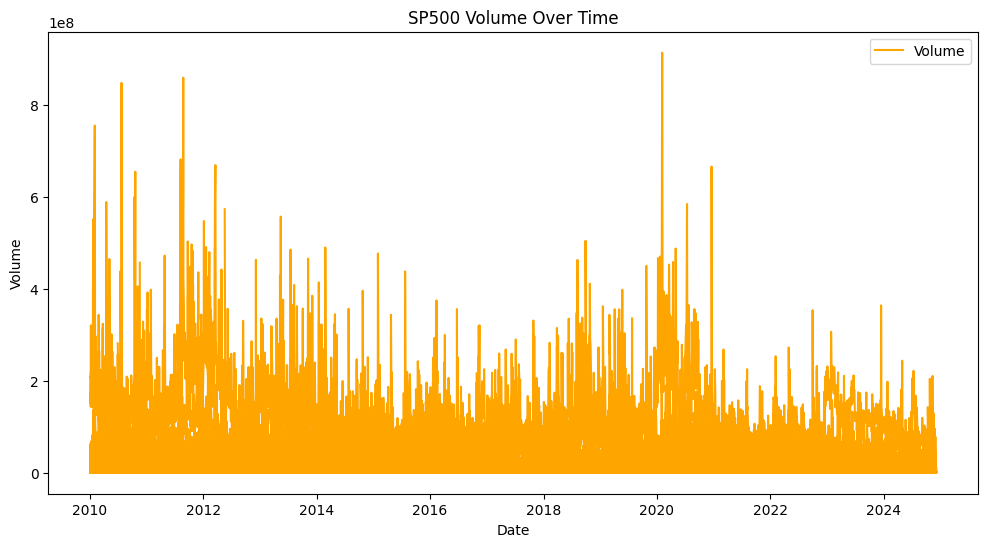

In [52]:
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['Volume'], color='orange', label='Volume')
plt.title('SP500 Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.show()

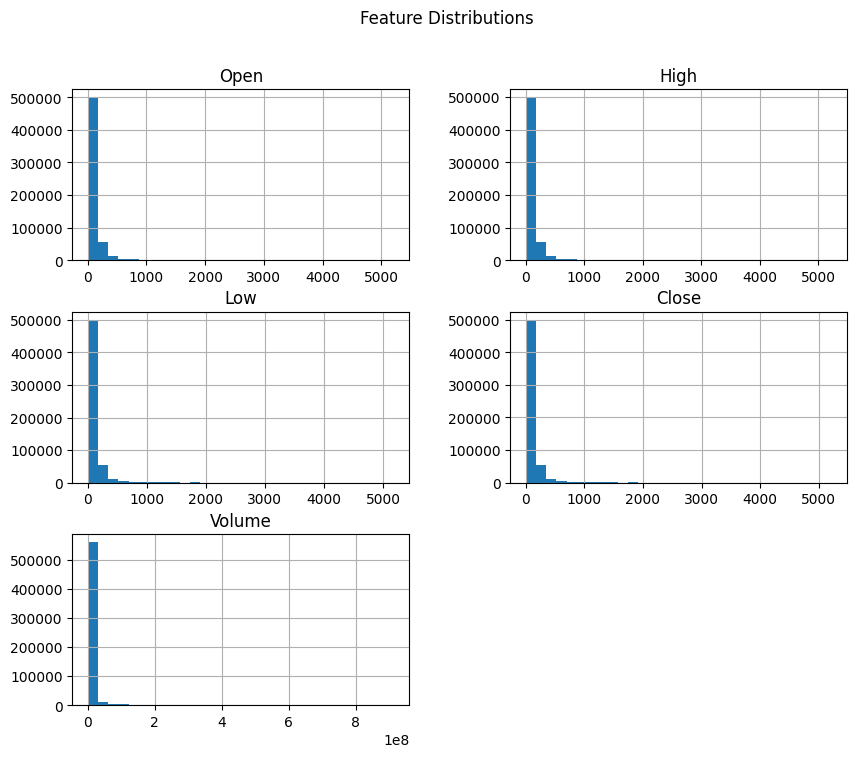

In [53]:
data[['Open', 'High', 'Low', 'Close', 'Volume']].hist(figsize=(10, 8), bins=30)
plt.suptitle('Feature Distributions')
plt.show()

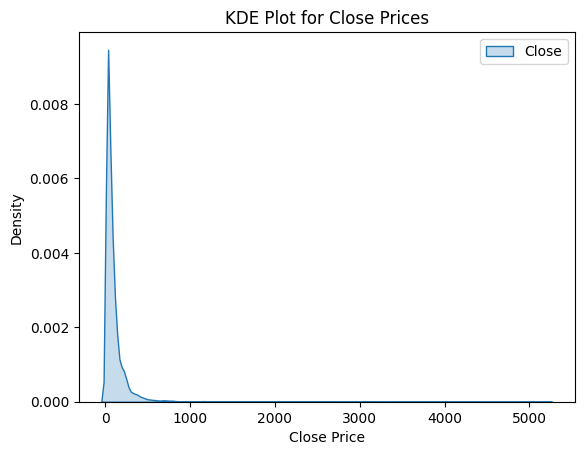

In [54]:
sns.kdeplot(data['Close'], label='Close', fill=True)
plt.title('KDE Plot for Close Prices')
plt.xlabel('Close Price')
plt.legend()
plt.show()

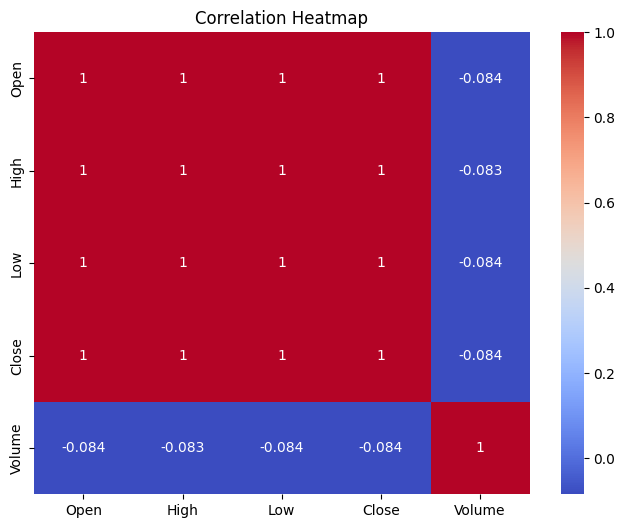

In [55]:
corr_matrix = data[['Open', 'High', 'Low', 'Close', 'Volume']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [56]:
def data_split(data):
    train_data = data[(data['Date'] >= '2010-01-01') & (data['Date'] < '2022-07-01')]
    val_data = data[(data['Date'] >= '2022-07-01') & (data['Date'] < '2024-01-01')]
    test_data = data[data['Date'] >= '2024-01-01']

    X_train = train_data.drop(['Date', 'Symbol', 'Target'], axis=1)
    y_train = train_data['Target']
    X_test = test_data.drop(['Date', 'Symbol', 'Target'], axis=1)
    y_test = test_data['Target']
    X_val = val_data.drop(['Date', 'Symbol', 'Target'], axis=1)
    y_val = val_data['Target']

    return X_train, y_train, X_test, y_test, X_val, y_val 

In [57]:
def calculate_mase(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    absolute_error = np.abs(y_true - y_pred)
    
    naive_error = np.abs(np.diff(y_true))

    mean_naive_error = np.mean(naive_error)
    
    if mean_naive_error == 0:
        return float('nan')  

    mase = np.mean(absolute_error[1:] / mean_naive_error)  
    return mase


In [58]:
def RandomForestModel(X_train, y_train, X_val, X_test):
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    y_val_pred = rf_model.predict(X_val)
    y_test_pred = rf_model.predict(X_test)
    return y_val_pred, y_test_pred

def XGBRegressorModel(X_train, y_train, X_val, X_test):
    xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
    xgb_model.fit(X_train, y_train)
    y_val_pred = xgb_model.predict(X_val)
    y_test_pred = xgb_model.predict(X_test)
    return y_val_pred, y_test_pred

def SVRModel(X_train, y_train, X_val, X_test):
    svr_model = SVR(kernel='rbf', C=100, gamma=0.1)
    svr_model.fit(X_train, y_train)
    y_val_pred = svr_model.predict(X_val)
    y_test_pred = svr_model.predict(X_test)
    return y_val_pred, y_test_pred


In [59]:
def evaluate_models_for_all_companies(empresa_df):
    results = []

    for empresa_name, empresa_df in empresas_dataframes.items():
        print(f"Avaliando {empresa_name}...")
        X_train, y_train, X_test, y_test, X_val, y_val = data_split(empresa_df)

        company_results = {'Empresa': empresa_name}

        y_val_pred_rf, y_test_pred_rf = RandomForestModel(X_train, y_train, X_val, X_test)
        rmse_val_rf = np.sqrt(mean_squared_error(y_val, y_val_pred_rf))
        mae_val_rf = mean_absolute_error(y_val, y_val_pred_rf)
        mape_val_rf = calculate_mase(y_val, y_val_pred_rf)

        rmse_test_rf = np.sqrt(mean_squared_error(y_test, y_test_pred_rf))
        mae_test_rf = mean_absolute_error(y_test, y_test_pred_rf)
        mape_test_rf = calculate_mase(y_test, y_test_pred_rf)

        company_results.update({
            'RF_Val_RMSE': rmse_val_rf, 'RF_Val_MAE': mae_val_rf, 'RF_Val_MASE': mape_val_rf,
            'RF_Test_RMSE': rmse_test_rf, 'RF_Test_MAE': mae_test_rf, 'RF_Test_MASE': mape_test_rf
        })

        y_val_pred_xgb, y_test_pred_xgb = XGBRegressorModel(X_train, y_train, X_val, X_test)
        rmse_val_xgb = np.sqrt(mean_squared_error(y_val, y_val_pred_xgb))
        mae_val_xgb = mean_absolute_error(y_val, y_val_pred_xgb)
        mape_val_xgb = calculate_mase(y_val, y_val_pred_xgb)

        rmse_test_xgb = np.sqrt(mean_squared_error(y_test, y_test_pred_xgb))
        mae_test_xgb = mean_absolute_error(y_test, y_test_pred_xgb)
        mape_test_xgb = calculate_mase(y_test, y_test_pred_xgb)

        company_results.update({
            'XGB_Val_RMSE': rmse_val_xgb, 'XGB_Val_MAE': mae_val_xgb, 'XGB_Val_MASE': mape_val_xgb,
            'XGB_Test_RMSE': rmse_test_xgb, 'XGB_Test_MAE': mae_test_xgb, 'XGB_Test_MASE': mape_test_xgb
        })

        y_val_pred_svr, y_test_pred_svr = SVRModel(X_train, y_train, X_val, X_test)
        rmse_val_svr = np.sqrt(mean_squared_error(y_val, y_val_pred_svr))
        mae_val_svr = mean_absolute_error(y_val, y_val_pred_svr)
        mape_val_svr = calculate_mase(y_val, y_val_pred_svr)

        rmse_test_svr = np.sqrt(mean_squared_error(y_test, y_test_pred_svr))
        mae_test_svr = mean_absolute_error(y_test, y_test_pred_svr)
        mape_test_svr = calculate_mase(y_test, y_test_pred_svr)

        company_results.update({
            'SVR_Val_RMSE': rmse_val_svr, 'SVR_Val_MAE': mae_val_svr, 'SVR_Val_MASE': mape_val_svr,
            'SVR_Test_RMSE': rmse_test_svr, 'SVR_Test_MAE': mae_test_svr, 'SVR_Test_MASE': mape_test_svr
        })

        results.append(company_results)

    results_df = pd.DataFrame(results)

    results_df.to_csv("model_evaluation_results.csv", index=False)

    print("Resultados salvos no CSV!")


evaluate_models_for_all_companies(empresas_dataframes)

Avaliando AMD...
Avaliando APD...
Avaliando ABNB...
Avaliando AKAM...
Avaliando ALGN...
Avaliando ALLE...
Avaliando LNT...
Avaliando AMZN...
Avaliando AMCR...
Avaliando AMTM...
Avaliando AMT...
Avaliando ADI...
Avaliando AMAT...
Avaliando ATO...
Avaliando AZO...
Avaliando AVY...
Avaliando BAC...
Avaliando BDX...
Avaliando TECH...
Avaliando BX...
Avaliando BKNG...
Avaliando BWA...
Avaliando BF-B...
Avaliando BLDR...
Avaliando BG...
Avaliando BXP...
Avaliando CDNS...
Avaliando CPB...
Avaliando CTLT...
Avaliando CNC...
Avaliando CF...
Avaliando CRL...
Avaliando CB...
Avaliando CINF...
Avaliando CLX...
Avaliando CMS...
Avaliando CAG...
Avaliando ED...
Avaliando CEG...
Avaliando CPRT...
Avaliando CRWD...
Avaliando CCI...
Avaliando DVA...
Avaliando DE...
Avaliando FANG...
Avaliando DOV...
Avaliando DHI...
Avaliando DD...
Avaliando ETN...
Avaliando ELV...
Avaliando EQT...
Avaliando EFX...
Avaliando EQIX...
Avaliando ESS...
Avaliando EG...
Avaliando EXPE...
Avaliando FICO...
Avaliando FAST...


In [60]:
results = pd.read_csv('model_evaluation_results.csv')

def print_average_metrics(df):
    rf_val_rmse_avg = df['RF_Val_RMSE'].mean()
    rf_val_mae_avg = df['RF_Val_MAE'].mean()
    rf_val_mape_avg = df['RF_Val_MASE'].mean()

    rf_test_rmse_avg = df['RF_Test_RMSE'].mean()
    rf_test_mae_avg = df['RF_Test_MAE'].mean()
    rf_test_mape_avg = df['RF_Test_MASE'].mean()

    xgb_val_rmse_avg = df['XGB_Val_RMSE'].mean()
    xgb_val_mae_avg = df['XGB_Val_MAE'].mean()
    xgb_val_mape_avg = df['XGB_Val_MASE'].mean()

    xgb_test_rmse_avg = df['XGB_Test_RMSE'].mean()
    xgb_test_mae_avg = df['XGB_Test_MAE'].mean()
    xgb_test_mape_avg = df['XGB_Test_MASE'].mean()

    svr_val_rmse_avg = df['SVR_Val_RMSE'].mean()
    svr_val_mae_avg = df['SVR_Val_MAE'].mean()
    svr_val_mape_avg = df['SVR_Val_MASE'].mean()

    svr_test_rmse_avg = df['SVR_Test_RMSE'].mean()
    svr_test_mae_avg = df['SVR_Test_MAE'].mean()
    svr_test_mape_avg = df['SVR_Test_MASE'].mean()

    print("Média das métricas para cada modelo:")
    
    print(f"\nRandom Forest:")
    print(f"  Validação - RMSE médio: {rf_val_rmse_avg:.4f}, MAE médio: {rf_val_mae_avg:.4f}, MASE médio: {rf_val_mape_avg:.4f}")
    print(f"  Teste - RMSE médio: {rf_test_rmse_avg:.4f}, MAE médio: {rf_test_mae_avg:.4f}, MASE médio: {rf_test_mape_avg:.4f}")
    
    print(f"\nXGBoost:")
    print(f"  Validação - RMSE médio: {xgb_val_rmse_avg:.4f}, MAE médio: {xgb_val_mae_avg:.4f}, MASE médio: {xgb_val_mape_avg:.4f}")
    print(f"  Teste - RMSE médio: {xgb_test_rmse_avg:.4f}, MAE médio: {xgb_test_mae_avg:.4f}, MASE médio: {xgb_test_mape_avg:.4f}")
    
    print(f"\nSVR:")
    print(f"  Validação - RMSE médio: {svr_val_rmse_avg:.4f}, MAE médio: {svr_val_mae_avg:.4f}, MASE médio: {svr_val_mape_avg:.4f}")
    print(f"  Teste - RMSE médio: {svr_test_rmse_avg:.4f}, MAE médio: {svr_test_mae_avg:.4f}, MASE médio: {svr_test_mape_avg:.4f}")
    
print_average_metrics(results)

Média das métricas para cada modelo:

Random Forest:
  Validação - RMSE médio: 14.8528, MAE médio: 11.0972, MASE médio: 3.1591
  Teste - RMSE médio: 53.3801, MAE médio: 50.0387, MASE médio: 10.2894

XGBoost:
  Validação - RMSE médio: 15.3634, MAE médio: 11.5531, MASE médio: 3.3415
  Teste - RMSE médio: 54.5631, MAE médio: 51.2500, MASE médio: 10.6755

SVR:
  Validação - RMSE médio: 104.0325, MAE médio: 100.7745, MASE médio: 34.9454
  Teste - RMSE médio: 154.9191, MAE médio: 152.8061, MASE médio: 44.5630


In [ ]:
def monte_carlo_with_ml(empresas_dataframes, num_simulations=1000):
    results = []
    
    for empresa_name, empresa_df in empresas_dataframes.items():
        X_train, y_train, X_test, _, X_val, _ = data_split(empresa_df)
        print(f"Simulando para {empresa_name}...")
        

        rf_pred_val, _ = RandomForestModel(X_train, y_train, X_val, X_test)
        xgb_pred_val, _ = XGBRegressorModel(X_train, y_train, X_val, X_test)
        svr_pred_val, _ = SVRModel(X_train, y_train, X_val, X_test)
        

        monte_carlo_results = []
        
        for _ in range(num_simulations):
            rf_simulated_returns = np.random.normal(rf_pred_val, 0.02)  
            xgb_simulated_returns = np.random.normal(xgb_pred_val, 0.02)
            svr_simulated_returns = np.random.normal(svr_pred_val, 0.02)
            
            portfolio_return = np.mean(rf_simulated_returns) + np.mean(xgb_simulated_returns) + np.mean(svr_simulated_returns)
            portfolio_risk = np.std(rf_simulated_returns) + np.std(xgb_simulated_returns) + np.std(svr_simulated_returns)
            
            monte_carlo_results.append((portfolio_return, portfolio_risk))
        
        results.append({
            'Empresa': empresa_name,
            'Simulações': monte_carlo_results
        })
    
    return results

In [62]:
simulations = monte_carlo_with_ml(empresas_dataframes)

Simulando para AMD...
Simulando para APD...
Simulando para ABNB...
Simulando para AKAM...
Simulando para ALGN...
Simulando para ALLE...
Simulando para LNT...
Simulando para AMZN...
Simulando para AMCR...
Simulando para AMTM...
Simulando para AMT...
Simulando para ADI...
Simulando para AMAT...
Simulando para ATO...
Simulando para AZO...
Simulando para AVY...
Simulando para BAC...
Simulando para BDX...
Simulando para TECH...
Simulando para BX...
Simulando para BKNG...
Simulando para BWA...
Simulando para BF-B...
Simulando para BLDR...
Simulando para BG...
Simulando para BXP...
Simulando para CDNS...
Simulando para CPB...
Simulando para CTLT...
Simulando para CNC...
Simulando para CF...
Simulando para CRL...
Simulando para CB...
Simulando para CINF...
Simulando para CLX...
Simulando para CMS...
Simulando para CAG...
Simulando para ED...
Simulando para CEG...
Simulando para CPRT...
Simulando para CRWD...
Simulando para CCI...
Simulando para DVA...
Simulando para DE...
Simulando para FANG..

In [ ]:
for simulation in simulations:
    empresa_name = simulation['Empresa']
    monte_carlo_results = simulation['Simulações']  

    portfolio_returns = [result[0] for result in monte_carlo_results]  
    portfolio_risks = [result[1] for result in monte_carlo_results]    

    mean_return = np.mean(portfolio_returns)
    mean_risk = np.mean(portfolio_risks)

    print(f"Empresa: {empresa_name}")
    print(f"Média dos retornos simulados: {mean_return}")
    print(f"Média do risco (desvio padrão) do portfólio: {mean_risk}")

Empresa: AMD
Média dos retornos simulados: 214.9245960156829
Média do risco (desvio padrão) do portfólio: 39.4862716446709
Empresa: APD
Média dos retornos simulados: 702.8590169158969
Média do risco (desvio padrão) do portfólio: 43.251571179178974
Empresa: ABNB
Média dos retornos simulados: 399.4298333101185
Média do risco (desvio padrão) do portfólio: 33.04663917886345
Empresa: AKAM
Média dos retornos simulados: 249.58965474573273
Média do risco (desvio padrão) do portfólio: 22.89019773114729
Empresa: ALGN
Média dos retornos simulados: 665.3997126740542
Média do risco (desvio padrão) do portfólio: 114.40937652865725
Empresa: ALLE
Média dos retornos simulados: 301.44071237625195
Média do risco (desvio padrão) do portfólio: 15.886492372845783
Empresa: LNT
Média dos retornos simulados: 144.09614382509253
Média do risco (desvio padrão) do portfólio: 7.474750050314849
Empresa: AMZN
Média dos retornos simulados: 294.3103266441773
Média do risco (desvio padrão) do portfólio: 39.2664216113511